In [1]:
import math
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
# torch.autograd tự động tính các gradient cho hàm f phức tạp dạng NNs thay vì tính đạo hàm bằng sympy (cần có biểu thức hàm f đơn giản)
# tận dụng GPU (cuda) để tính nhanh hơn, accuracy cao hơn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    giải bài toán giá trị ban đầu bằng pp Euler => tính giá trị tiếp theo của nghiệm z_n+1 dựa trên giá trị hiện tại z_n mà không cần giải phương trình
    z0: trạng thái đầu
    t0: thời điểm đầu
    t1: thời điểm kết thúc
    f: output của NNs
    
    
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

In [3]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [4]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [5]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

In [6]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-1, -0.2], [5., -4]]).to(device))

In [7]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2).to(device)/2.)

In [8]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

In [9]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [10]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=None, return_whole_sequence=False):
        if t is None:
            t = Tensor([0., 1.]).to(device)
        t = t.to(z0.device)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [11]:
def to_np(x):
    return x.detach().cpu().numpy()

In [12]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [13]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    # z0 = Variable(torch.Tensor([[0.6, 0.3]])).to(device)

    # t_max = 6.29*5
    # n_points = 200

    z0 = Variable(torch.Tensor([[0.1, 0.1]])).to(device)

    # Reduce time span significantly for exponential growth
    t_max = 2.0 *5 # Reduced from 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"assets/imgs/{name}/{i}.png")
            clear_output(wait=True)

In [14]:
class ExponentialGrowthODEF(ODEF):
    def __init__(self):
        super(ExponentialGrowthODEF, self).__init__()
        # Initialize the linear transformation
        self.linear = nn.Linear(2, 2, bias=False)
        # Set the weight matrix for exponential growth
        self.linear.weight = nn.Parameter(
            Tensor([[1.0, 0.0],
                   [0.0, 1.0]]).to(device)
        )

    def forward(self, x, t):
        # Implement y = x*e^t
        # t needs to be reshaped to match x's dimensions
        t_expanded = t.expand(x.shape[0], 1)
        exponential = torch.exp(t_expanded)
        return self.linear(x) * exponential


In [15]:
# Usage example:
ode_true = NeuralODE(ExponentialGrowthODEF()).to(device)
ode_trained = NeuralODE(RandomLinearODEF()).to(device)

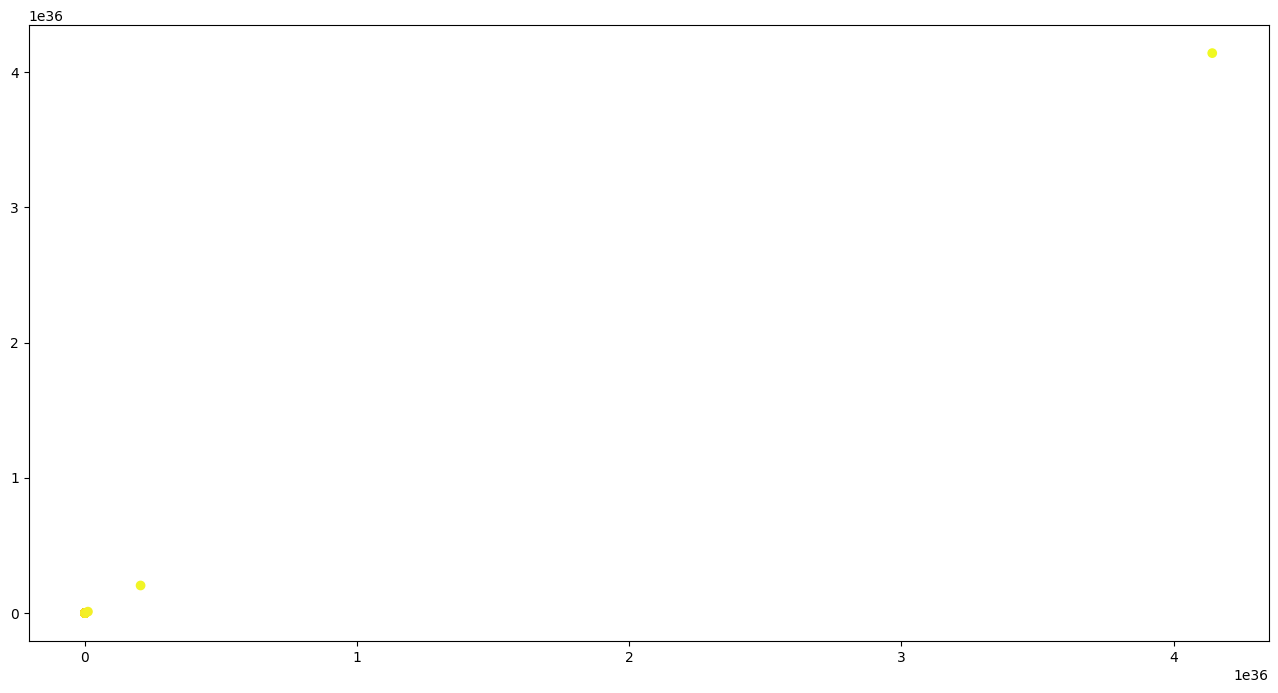

In [16]:
# Experiment with shorter time span since exponential growth can be explosive
conduct_experiment(ode_true, ode_trained, 1000, "comp", plot_freq=50)

In [17]:
func = TestODEF(Tensor([[-1, -0.5], [5, -10]]).to(device), Tensor([[20, 0.1], [-1.5, 5.2]]).to(device), Tensor([[-1., 0.]]).to(device))
ode_true = NeuralODE(func).to(device)

func = NNODEF(2, 16, time_invariant=True).to(device)
ode_trained = NeuralODE(func).to(device)

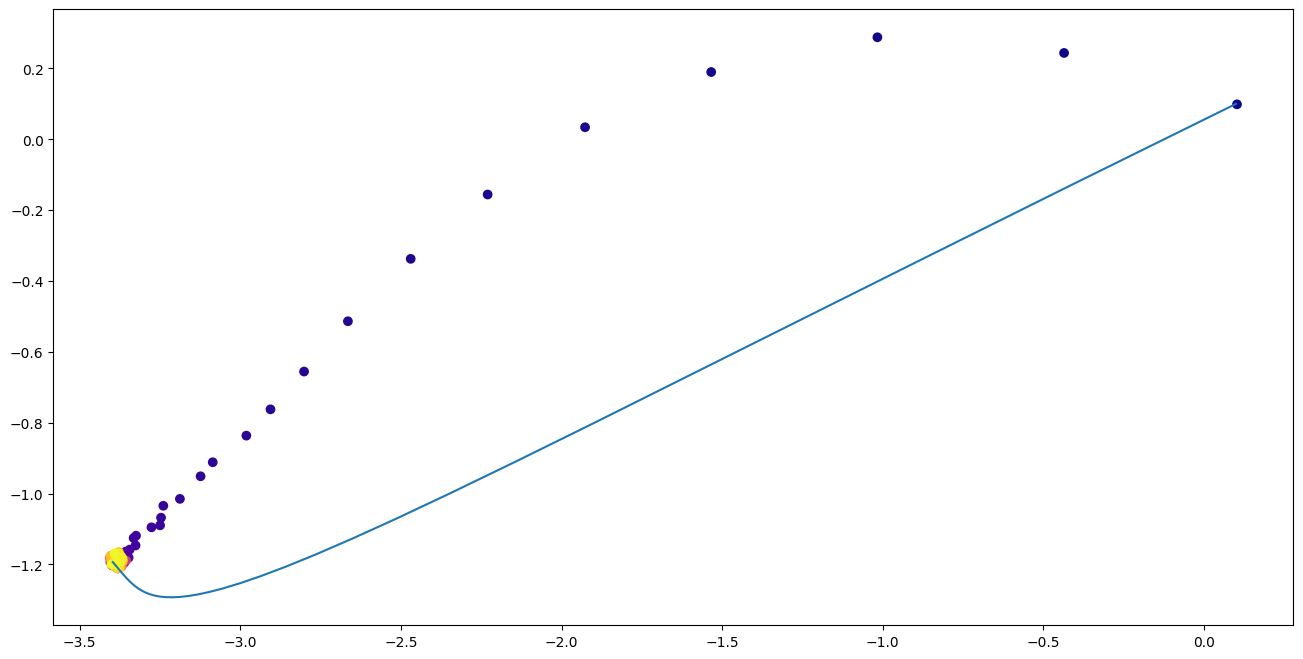

In [18]:
conduct_experiment(ode_true, ode_trained, 2000, "comp", plot_freq=100)


In [19]:
ode_true = NeuralODE(SpiralFunctionExample()).to(device)
ode_trained = NeuralODE(RandomLinearODEF()).to(device)

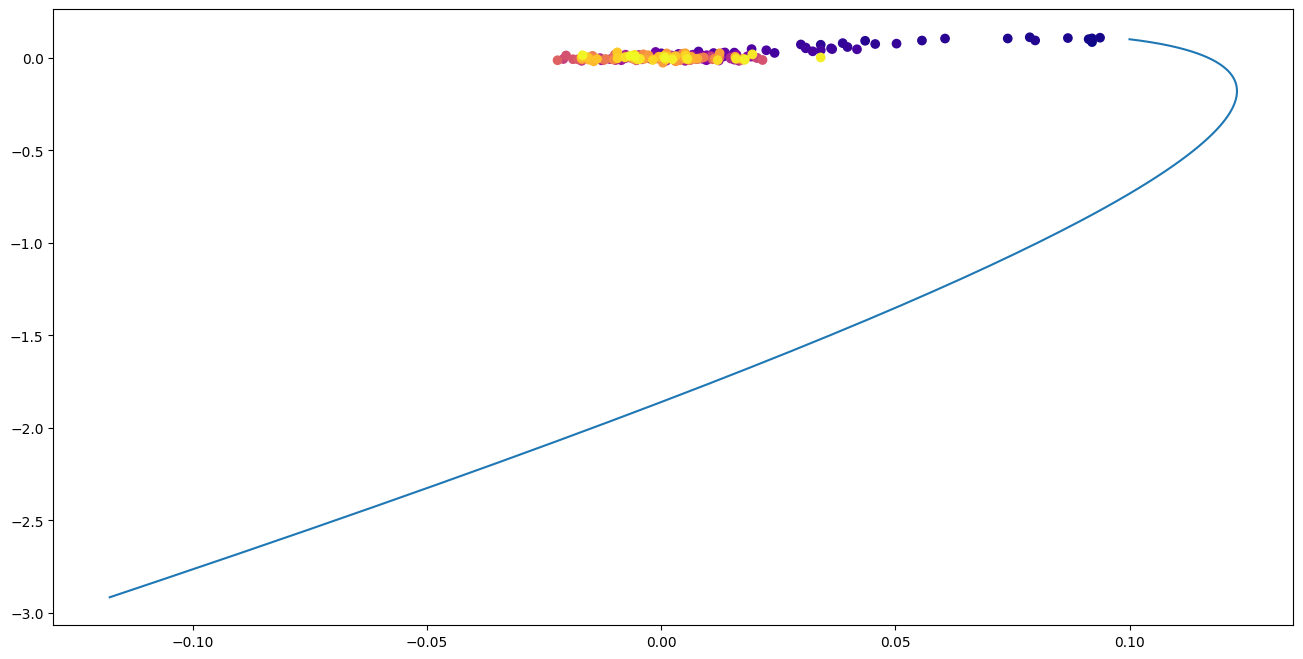

In [20]:
conduct_experiment(ode_true, ode_trained, 1000, "linear")


Thesis_UAV_NeuralODE/
├── notebooks/                     # Nơi chứa các file .ipynb cho thí nghiệm
│   ├── 01_Data_Preprocessing_UAV.ipynb
│   ├── 02_NeuralODE_7features_IrregularData.ipynb
│   ├── 03_LSTM_7features_RegularData.ipynb
│   └── ... (các notebook khác nếu có)
├── src/                           # Nơi chứa code Python tái sử dụng được
│   ├── __init__.py
│   ├── ode_solvers.py             # Chứa hàm ode_solve (và có thể các bộ giải khác sau này)
│   ├── neural_ode_core.py         # Chứa ODEF, ODEAdjoint, NeuralODE
│   ├── vae_architectures.py       # Chứa RNNEncoder, NeuralODEDecoder, ODEVAE
│   ├── lstm_model.py              # Chứa kiến trúc mô hình LSTM
│   └── utils.py                   # Chứa các hàm tiện ích (ví dụ: chuẩn hóa, vẽ đồ thị)
├── data/                          # Nơi chứa dữ liệu
│   ├── raw/
│   │   └── uav_navigation_dataset.csv
│   └── processed/                 # Nơi lưu dữ liệu đã tiền xử lý
│       ├── uav_7features_regular_train.pt
│       ├── uav_7features_irregular_train.pt
│       └── ...
├── results/                       # Nơi lưu kết quả, đồ thị, model checkpoints
└── README.md